# ANALYSIS

Once we have the dataset prepared, we are going to make the time-series and the analysis of our 3 main variables: tmed, prec and sol.

### Importing some libraries and the csv generated in the CleaningData document.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import src.Cleaning_f as fc

In [2]:
import pandas as pd
import numpy as np
# El mantra de las visualizaciones
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
DA_Cl = pd.read_csv('data/DA_Cl.csv', index_col=0 ,encoding = "ISO-8859-1")

### Preparing the Index for the Time-series

In [4]:
DA_Cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4014 entries, 2010-01-01 to 2020-12-31
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tmed      4014 non-null   float64
 1   prec      4014 non-null   float64
 2   tmin      4014 non-null   float64
 3   tmax      4014 non-null   float64
 4   dir       4014 non-null   float64
 5   velmedia  4014 non-null   float64
 6   racha     4014 non-null   float64
 7   sol       4014 non-null   float64
 8   presMax   4014 non-null   float64
 9   presMin   4014 non-null   float64
dtypes: float64(10)
memory usage: 345.0+ KB


In [5]:
DA_Cl.index = pd.to_datetime(DA_Cl.index)

In [6]:
DA_Cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4014 entries, 2010-01-01 to 2020-12-31
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tmed      4014 non-null   float64
 1   prec      4014 non-null   float64
 2   tmin      4014 non-null   float64
 3   tmax      4014 non-null   float64
 4   dir       4014 non-null   float64
 5   velmedia  4014 non-null   float64
 6   racha     4014 non-null   float64
 7   sol       4014 non-null   float64
 8   presMax   4014 non-null   float64
 9   presMin   4014 non-null   float64
dtypes: float64(10)
memory usage: 345.0 KB


In [7]:
DATA = DA_Cl.resample('d').sum()

In [8]:
DATA.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='fecha', length=4018, freq='D')

In [9]:
DATA.isna().sum()

tmed        0
prec        0
tmin        0
tmax        0
dir         0
velmedia    0
racha       0
sol         0
presMax     0
presMin     0
dtype: int64

In [10]:
len(DA_Cl)

4014

In [11]:
len(DATA)

4018

We can see that by changing the frequency to daily, 4 new rows have been generated. This is due to the fact that we were missing data for 4 days of these 10 years. In order to avoid influencing our analysis, we are going to look for these new rows and fill them with the average of the previous and following days using the function saca_medias defined in the Cleaning_f document.

In [12]:
reqd_Index = DATA[DATA['tmed']==0].index.tolist()
print(reqd_Index)

[Timestamp('2016-12-09 00:00:00'), Timestamp('2016-12-10 00:00:00'), Timestamp('2016-12-11 00:00:00'), Timestamp('2019-04-23 00:00:00')]


In [13]:
DATA.loc['2016-12-08':'2016-12-12']

,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
fecha,,,,,,,,,,
2016-12-08,8.2,0.0,3.2,13.3,9.0,3.1,6.7,3.9,973.4,970.8
2016-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-12,7.5,0.0,2.0,13.0,12.0,1.7,4.4,6.1,973.4,970.8


In [14]:
DATA.loc['2019-04-22':'2019-04-24']

,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
fecha,,,,,,,,,,
2019-04-22,14.0,1.6,6.8,21.2,32.0,3.1,10.8,10.5,947.9,938.7
2019-04-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-24,10.8,5.0,6.0,15.5,29.0,5.8,19.2,0.6,946.9,943.7


In [15]:
DATA_me = DATA.drop(['2016-12-09 00:00:00','2016-12-10 00:00:00','2016-12-11 00:00:00','2019-04-23 00:00:00'])

In [16]:
len(DATA_me)

4014

In [17]:
colmns = (DATA_me.tmed,DATA_me.prec,DATA_me.tmin,DATA_me.tmax,DATA_me.dir,DATA_me.velmedia,DATA_me.racha,DATA_me.sol,DATA_me.presMax,DATA_me.presMin)
new_cols = fc.get_med(colmns,'2016-12-06','2016-12-14')
new_cols

[7.916666666666665,
 2.4,
 3.483333333333333,
 12.383333333333333,
 10.5,
 2.233333333333333,
 5.55,
 2.966666666666667,
 966.8666666666668,
 961.9166666666669]

In [18]:
DATA.loc['2016-12-09 00:00:00'] = new_cols
DATA.loc['2016-12-10 00:00:00'] = new_cols
DATA.loc['2016-12-11 00:00:00'] = new_cols

In [19]:
DATA.loc['2016-12-08':'2016-12-12']

,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
fecha,,,,,,,,,,
2016-12-08,8.200000,0.0,3.200000,13.300000,9.0,3.100000,6.70,3.900000,973.400000,970.800000
2016-12-09,7.916667,2.4,3.483333,12.383333,10.5,2.233333,5.55,2.966667,966.866667,961.916667
2016-12-10,7.916667,2.4,3.483333,12.383333,10.5,2.233333,5.55,2.966667,966.866667,961.916667
2016-12-11,7.916667,2.4,3.483333,12.383333,10.5,2.233333,5.55,2.966667,966.866667,961.916667
2016-12-12,7.500000,0.0,2.000000,13.000000,12.0,1.700000,4.40,6.100000,973.400000,970.800000


In [20]:
DATA.loc['2019-04-22':'2019-04-24']

,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
fecha,,,,,,,,,,
2019-04-22,14.0,1.6,6.8,21.2,32.0,3.1,10.8,10.5,947.9,938.7
2019-04-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-24,10.8,5.0,6.0,15.5,29.0,5.8,19.2,0.6,946.9,943.7


In [21]:
new_cols2 = fc.get_med(colmns,'2019-04-20','2019-04-27')
new_cols2

[13.1,
 1.4000000000000001,
 7.442857142857143,
 18.77142857142857,
 20.142857142857142,
 4.1000000000000005,
 12.171428571428574,
 7.200000000000001,
 957.4142857142857,
 950.6142857142856]

In [22]:
DATA.loc['2019-04-23 00:00:00'] = new_cols2

In [23]:
DATA.loc['2019-04-22':'2019-04-24']

,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
fecha,,,,,,,,,,
2019-04-22,14.0,1.6,6.800000,21.200000,32.000000,3.1,10.800000,10.5,947.900000,938.700000
2019-04-23,13.1,1.4,7.442857,18.771429,20.142857,4.1,12.171429,7.2,957.414286,950.614286
2019-04-24,10.8,5.0,6.000000,15.500000,29.000000,5.8,19.200000,0.6,946.900000,943.700000


Once we have the time-series data prepared, we can start with our analysis

## Analysis

### Stationarity

Since we are dealing with climate data over several years, we know that they are going to be stationary variables, but let's check anyway.

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
r_tmed = adfuller(DATA["tmed"])
r_tmed

(-3.7521255507956304,
 0.003436919859272403,
 30,
 3987,
 {'1%': -3.4319912127364143,
  '5%': -2.8622651980110834,
  '10%': -2.567156030734827},
 16417.405922336915)

In [26]:
pvalue = r_tmed[1]
pvalue

0.003436919859272403

In the case of tmed, the time series is stationary since pvalue < 0.05.

In [27]:
r_prec = adfuller(DATA["prec"])
r_prec

(-12.920324665589325,
 3.88688536906041e-24,
 17,
 4000,
 {'1%': -3.4319858753661405,
  '5%': -2.8622628402506254,
  '10%': -2.5671547755625},
 20620.90533701188)

In [28]:
pvalue = r_prec[1]
pvalue

3.88688536906041e-24

In the case of prec, the time series is stationary since pvalue < 0.05.

In [29]:
r_sol = adfuller(DATA["sol"])
r_sol

(-5.157917637392644,
 1.0708678870979847e-05,
 23,
 3994,
 {'1%': -3.431988334447595,
  '5%': -2.8622639265398497,
  '10%': -2.567155353857025},
 19776.57578313834)

In [30]:
pvalue = r_sol[1]
pvalue

1.0708678870979847e-05

In the case of sol, the time series is stationary since pvalue < 0.05.

### General Visualizations

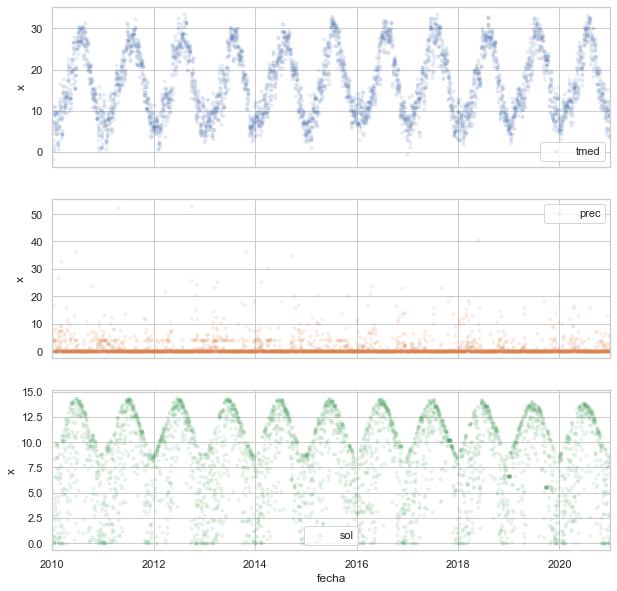

In [58]:
col_graf = ['tmed', 'prec', 'sol'] 
ejes = DATA[col_graf].plot(marker='.', alpha=0.1, linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
  eje.set_ylabel('x')

### Resampling

aqui reagrupo los datos con la media por trimestre

In [41]:
columnas = ['tmed','prec','sol']
media_clima_trimestral = DATA[columnas].resample('3M').mean()
media_clima_trimestral.head()

,tmed,prec,sol
fecha,,,
2010-01-31,6.293548,2.422581,3.616129
2010-04-30,11.014607,2.560674,6.553933
2010-07-31,22.443478,1.266304,11.235870
2010-10-31,21.522826,0.870652,9.182609
2011-01-31,7.825000,1.872826,4.663043


Comparo la visualizacion del datatime diario vs el trimestral

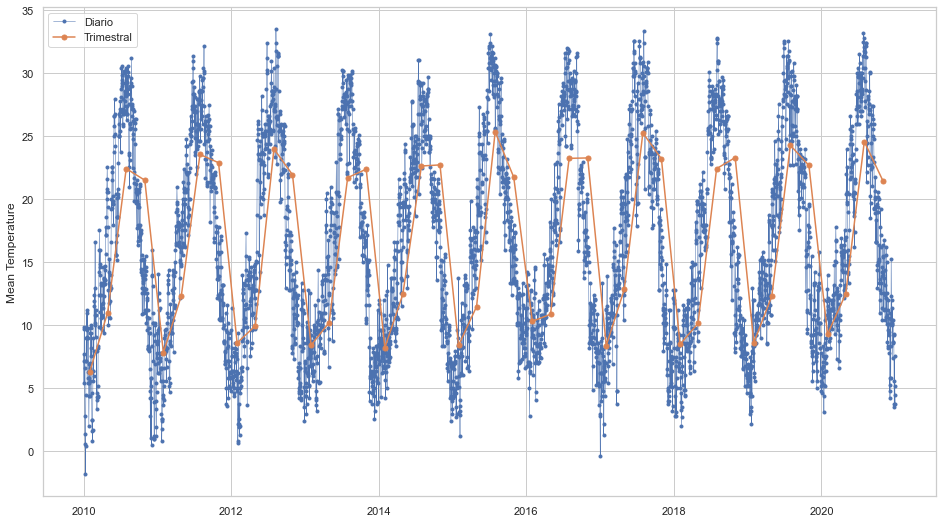

In [59]:
inicio, final = '2010-01','2020-12'
fig,eje = plt.subplots()
eje.plot(DATA.loc[inicio:final,'tmed'],marker='.',linestyle='-',linewidth=0.5,label='Diario')
eje.plot(media_clima_trimestral.loc[inicio:final,'tmed'],marker='o',markersize=5,label='Trimestral')
eje.set_ylabel('Mean Temperature')
eje.legend()

Aqui reagrupo mensualmente

In [44]:
clima_mensual = DATA[columnas].resample('M').sum()
clima_mensual.head()

,tmed,prec,sol
fecha,,,
2010-01-31,195.1,75.1,112.1
2010-02-28,212.7,86.7,125.9
2010-03-31,313.9,78.7,193.2
2010-04-30,453.7,62.5,264.2
2010-05-31,524.2,38.2,339.9


visualización de la agrupacion mensual (por la media) de las tres variables principales

Text(0, 0.5, 'Total Mensual (GWh)')

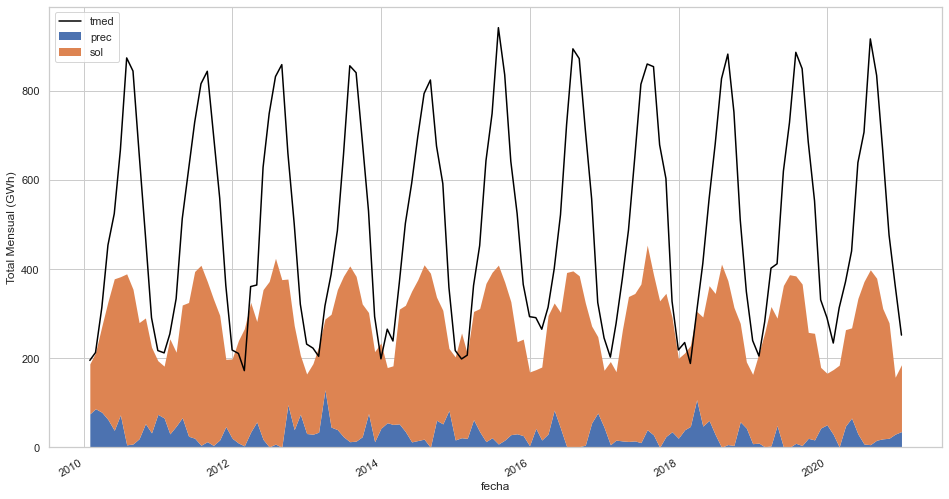

In [45]:
fig,eje = plt.subplots()
eje.plot(clima_mensual['tmed'],color='black',label='tmed')
clima_mensual[['prec','sol']].plot.area(ax=eje,linewidth=0)
eje.legend()
eje.set_ylabel('Total Mensual (GWh)')

VENTANAS DESLIZANTES

In [60]:
clima_7d = DATA[columnas].rolling(7, center=True).mean()
clima_7d.head()

,tmed,prec,sol
fecha,,,
2010-01-01,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN
2010-01-04,7.042857,5.128571,1.728571
2010-01-05,6.142857,5.128571,2.100000


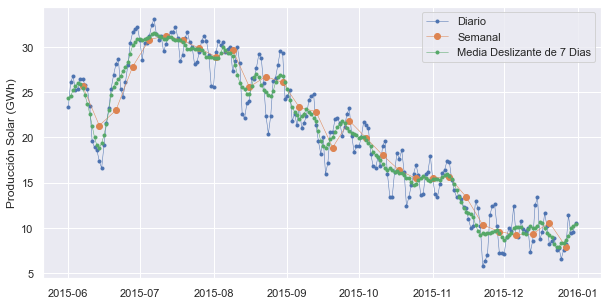

In [62]:
sns.set(rc={'figure.figsize':(10, 5)})

inicio, final='2015-06','2015-12'
fig, eje = plt.subplots()
eje.plot(DATA.loc[inicio:final, 'tmed'],marker='.',linestyle='-', linewidth=0.5,label='Diario')
eje.plot(media_clima_semanal.loc[inicio:final,'tmed'],marker='o',linestyle='-', linewidth=0.5,label='Semanal')
eje.plot(clima_7d.loc[inicio:final,'tmed'],marker='.',linestyle='-', linewidth=0.5,label='Media Deslizante de 7 Dias')
eje.set_ylabel('Producción Solar (GWh)')
eje.legend()

In [66]:
clima_365d = DATA[columnas].rolling(window=365,center=True).mean()

Text(0.5, 1.0, 'Tendencias en el Consumo Electrico')

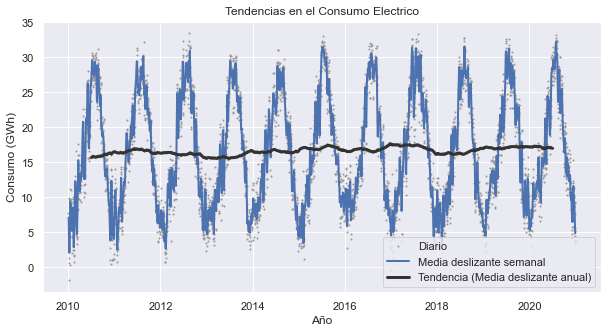

In [67]:
fig, eje = plt.subplots()
eje.plot(DATA['tmed'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Diario')
eje.plot(clima_7d['tmed'], linewidth=2, label='Media deslizante semanal')
eje.plot(clima_365d['tmed'], color='0.2', linewidth=3,
label='Tendencia (Media deslizante anual)')
eje.legend()
eje.set_xlabel('Year')
eje.set_ylabel('Mean Temperature')
eje.set_title('Tendencias en el Clima de Toledo')

### TRENDS

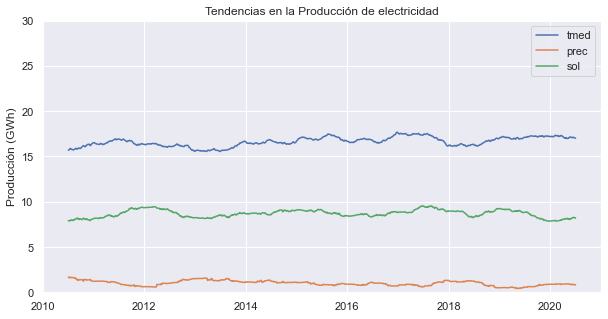

In [69]:
fig,eje= plt.subplots()
for i in ['tmed','prec','sol']:
    eje.plot(clima_365d[i],label=i)
    eje.set_ylim(0,30)
    eje.legend()
    eje.set_ylabel('Producción (GWh)')
    eje.set_title('Tendencias en el clima de Toledo')


#### tmed

In [ ]:
plt.plot(DATA["tmed"], label="tmed")
plt.title("Mean Temperature Toledo")
plt.plot(DATA['tmed'].expanding().mean(), c="purple", label="expanding window")
plt.legend();

#### prec

In [ ]:
plt.plot(DATA["prec"], label="prec")
plt.title("Precipitations Toledo")
plt.plot(DATA['prec'].expanding().mean(), c="purple", label="expanding window")
plt.legend();

#### sol

In [ ]:
plt.plot(DATA["sol"], label="sol")
plt.title("Sun Toledo")
plt.plot(DATA['sol'].expanding().mean(), c="purple", label="expanding window")
plt.legend();

### POR AQUI

In [ ]:
CORRELACION

In [ ]:
TENDENCIA

In [ ]:
TIME-SERIES POR AÑO

In [ ]:
import seaborn as sns
y = DATA['prec'].loc["2010-01-01":"2010-12-12"]
x = DATA.index[0:346]
plt.plot(x,y)
plt.show()

# POR AHORA POR AQUI

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})

temperatura media 2010

Text(0, 0.5, 'Mean Temperature (ºC)')

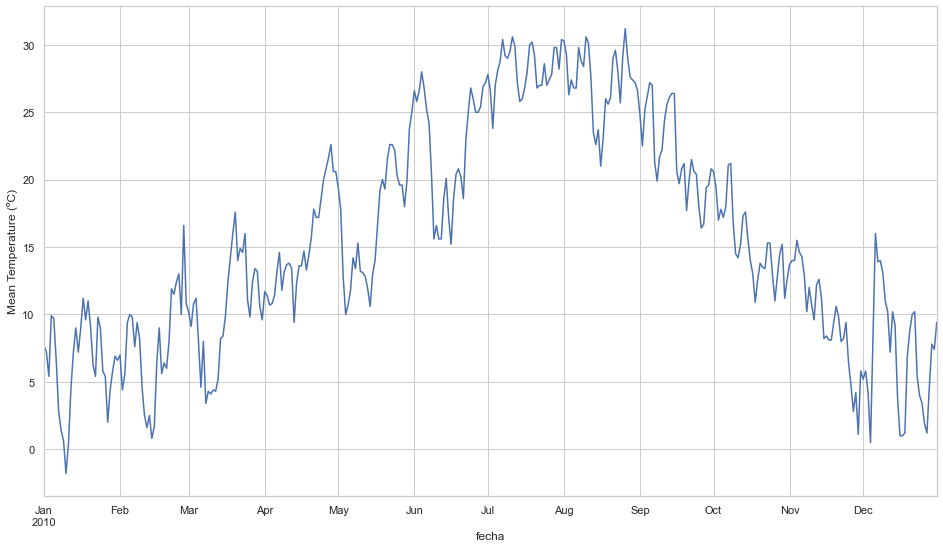

In [47]:
eje = DATA.loc['2010','tmed'].plot()
eje.set_ylabel('Mean Temperature (ºC)')

temperatura media enero febrero 2016

Text(0, 0.5, 'Mean Temperature (ºC)')

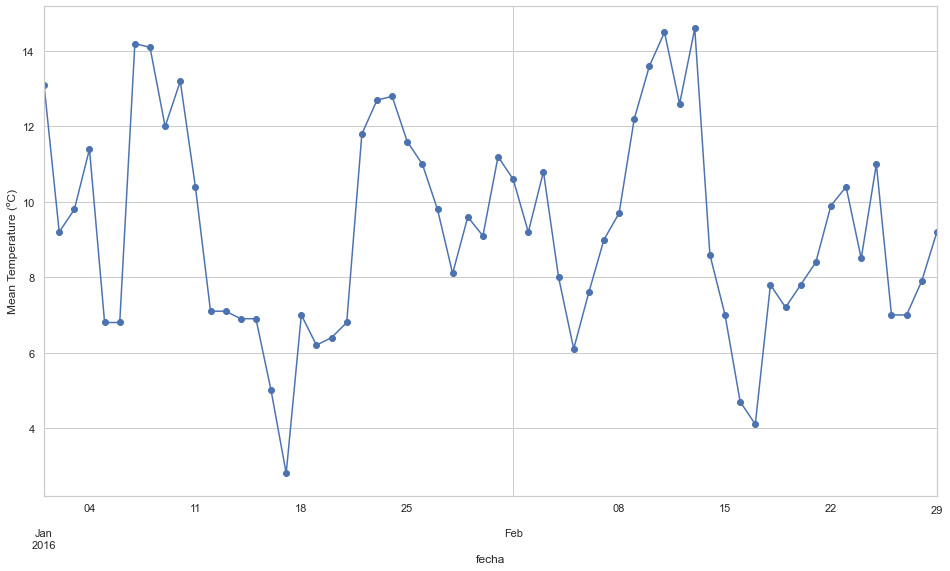

In [48]:
eje = DATA.loc['2016-01':'2016-02', 'tmed'].plot(marker='o',linestyle='-')
eje.set_ylabel('Mean Temperature (ºC)')

TENDENCIAS

In [ ]:
res = seasonal_decompose(DATA.tmed, model="additive")
res.plot();

In [ ]:
plt.title("Temperature")
plt.plot(DATA["tmed"], label="valor")
plt.plot(res.trend, label="tendencia")
plt.plot(res.seasonal, label="seasonal")
plt.legend();

In [ ]:
fc.get_med(colmns,'2010-01-01','2010-12-31')

In [ ]:
fc.get_med(colmns,'2011-01-01','2011-12-31')

In [ ]:
fc.get_med(colmns,'2012-01-01','2012-12-31')

In [ ]:
fc.get_med(colmns,'2013-01-01','2013-12-31')

In [ ]:
fc.get_med(colmns,'2014-01-01','2014-12-31')

In [ ]:
fc.get_med(colmns,'2015-01-01','2015-12-31')

In [ ]:
fc.get_med(colmns,'2016-01-01','2016-12-31')

In [ ]:
fc.get_med(colmns,'2017-01-01','2017-12-31')

In [ ]:
fc.get_med(colmns,'2018-01-01','2018-12-31')

In [ ]:
fc.get_med(colmns,'2019-01-01','2019-12-31')

In [ ]:
fc.get_med(colmns,'2020-01-01','2020-12-31')